In [1]:
import os,sys,string, time
import ROOT
from math import *
from ROOT import gPad, TTree, TObject, TFile, gDirectory, TH1D, TH2D, TH3D, TCanvas, gROOT, TGaxis, gStyle, TColor, TLegend, THStack, TChain, TLatex, TText, TCollection, kRed, kBlue
from array import array
import matplotlib.pyplot as plt
import numpy as np
import uproot
import pandas as pd
from root_pandas import read_root
from platform import python_version
import scipy
from scipy import stats
import uproot3
import math
from matplotlib.patches import Rectangle
import xgboost
from xgboost import XGBClassifier
import joblib
import seaborn as sns
import pickle

import Utilities.Plotter as PT
import Utilities.Constants as Constants
import Utilities.Variables_list as Variables
import Utilities.Functions as Functions

print ('Success')


Welcome to JupyROOT 6.24/06
Success


## Reading in files

In [2]:
Params = {"Run":"run1", #The run number, so far either "run1" or "run3"
          "Load_standard":True,
          "Load_DetVars":True,
          "Only_keep_common_DetVar_evs":True,
          "Load_data":False,
          "FLATTEN":True, #Have one row per reconstructed object in the analysis dataframe
          "only_presel":False, #Create small files containing only variables necessary for pre-selection, for making pre-selection plots
          "EXT_in_training":False} 

feature_names = Variables.First_pass_vars_for_BDT #All variables
feature_names_MC = feature_names + ["weight"]
loc_pkls = "pkl_files/"+Params["Run"]+"/current_files/my_vars/"

samples = Functions.create_test_samples_list(Params)

Loading these run1 samples: 
['overlay', 'dirtoverlay', 'beamoff', 20, 50, 100, 150, 180, 200, 'WireModX', 'WireModYZ', 'WireModThetaXZ', 'WireModThetaYZ', 'WireModdEdX', 'LYDown', 'LYRayleigh', 'LYAttenuation', 'SCE', 'Recomb2', 'CV']


In [3]:
sample_test_dict = {}
for sample in samples:
    if sample in Constants.Detector_variations: #Reading in an overlay DetVar sample
        loc=loc_pkls+"DetVars/"+"Preselected_overlay_"+Params["Run"]+"_my_vars"+f"_{sample}_flattened_reduced_evs.pkl"
        sample_test_dict[sample] = pd.read_pickle(loc)
    #elif sample in Constants.Signal_DetVars: #For signal DetVar samples
    else: #Standard sample types
        if sample == 'overlay':
            sample_test_dict[sample] = pd.read_pickle(loc_pkls+"BDT_Test_dfs/Test_overlay_"+Params["Run"]+"_my_vars_flattened.pkl")
        if sample in Constants.HNL_mass_samples:
            sample_test_dict[sample] = pd.read_pickle(loc_pkls+f"BDT_Test_dfs/Test_signal_{sample}_"+Params["Run"]+"_my_vars_flattened.pkl")
        elif (sample == 'beamoff') and (Params["EXT_in_training"] == True): #EXT only if extra EXT has been added
            sample_test_dict[sample] = pd.read_pickle(loc_pkls+"BDT_Test_dfs/Test_beamoff_"+Params["Run"]+"_my_vars_flattened.pkl")
        else: 
            sample_test_dict[sample] = pd.read_pickle(loc_pkls+f"Preselected_{sample}_"+Params["Run"]+"_my_vars_flattened.pkl")


In [4]:
bdt_vars = feature_names
xgb_test_dict = {}
for sample in sample_test_dict:
    xgb_test_dict[sample] = xgboost.DMatrix(sample_test_dict[sample][bdt_vars])
    # print("Done " + str(sample))

for HNL_mass in Constants.HNL_mass_samples:
    bdt = xgboost.Booster()
    bdt.load_model(f"bdts/"+Params["Run"]+f"_{HNL_mass}_MeV_My_variables_flattened_highest_E_1.json")
    for sample in xgb_test_dict:
        results = bdt.predict(xgb_test_dict[sample])
        sample_test_dict[sample][f"BDT_output_{HNL_mass}MeV"] = results

## Saving BDT output for reweighting systematics plots

In [6]:
pkl_results_loc = "pkl_files/"+Params["Run"]+"/current_files/Results/"

# print(sample_test_dict['overlay'].keys())

print_vals = input("Do you want to save the new BDT scores to .pkl files? y/n ")
if print_vals == "y":
    
    columns = Variables.event_vars + Variables.weight_related + ["weight"]
    for HNL_mass in Constants.HNL_mass_samples:
        columns.append(f'BDT_output_{HNL_mass}MeV')
    print(columns)
    
    overlay_to_save = sample_test_dict['overlay'][columns].copy()

    #df2 = overlay_merged_to_save.loc[:,~overlay_merged_to_save.columns.duplicated()] #Getting rid of duplicate "weight" column
    #df2.to_pickle(pkl_results_loc + "overlay_results.pkl")
    overlay_to_save.to_pickle(pkl_results_loc + "overlay_results.pkl")
    
    print(overlay_to_save.keys())

Do you want to save the new BDT scores to .pkl files? y/n  y


['run', 'sub', 'evt', 'weightSplineTimesTune', 'ppfx_cv', 'npi0', 'weight', 'BDT_output_20MeV', 'BDT_output_50MeV', 'BDT_output_100MeV', 'BDT_output_150MeV', 'BDT_output_180MeV', 'BDT_output_200MeV']
Index(['run', 'sub', 'evt', 'weightSplineTimesTune', 'ppfx_cv', 'npi0',
       'weight', 'BDT_output_20MeV', 'BDT_output_50MeV', 'BDT_output_100MeV',
       'BDT_output_150MeV', 'BDT_output_180MeV', 'BDT_output_200MeV'],
      dtype='object')


## Saving only high BDT Score events for variable study

In [8]:
cutoff = 0.95
signal_like = {}
frac_retained = {}
pkl_variable_tests_loc = "pkl_files/"+Params["Run"]+"/current_files/Variable_tests/"
for HNL_mass in Constants.HNL_mass_samples:
    signal_like[HNL_mass] = sample_test_dict[HNL_mass].query(f"BDT_output_{HNL_mass}MeV > {cutoff}")
    frac_retained[HNL_mass] = len(signal_like[HNL_mass])/len(sample_test_dict[HNL_mass])
    
    signal_like[HNL_mass].to_pickle(pkl_variable_tests_loc + f"signal_like_{HNL_mass}_MeV.pkl")
    
print(frac_retained)

{20: 0.599705304518664, 50: 0.5728995057660626, 100: 0.46100065545116886, 150: 0.47742831630122035, 180: 0.31082020389249304, 200: 0.22048054919908466}


## Plotting BDT outputs

In [5]:
#Needs to be rewritten, perhaps made into a function
train_vs_test_fraction = 0.7 #This was set in 3_BDT_training, need to change if I have changed this there.
SF_test = 1.0/(1-train_vs_test_fraction)
    
if Params["Run"] == "run1":
    overlay_scale = Constants.SF_overlay_run1*SF_test
    EXT_scale_list = np.ones(len(sample_test_dict['beamoff'][f'BDT_output_{HNL_mass}MeV']))*Constants.SF_EXT_run1
    dirt_scale = Constants.SF_dirt_run1
        
elif Params["Run"] == "run3":
    overlay_scale = Constants.SF_overlay_run3*SF_test
    EXT_scale_list = np.ones(len(sample_test_dict['beamoff'][f'BDT_output_{HNL_mass}MeV']))*Constants.SF_EXT_run3
    dirt_scale = Constants.SF_dirt_run3

print("Creating the sample and normalisation dictionaries")    
samples_plot={'overlay_test':sample_test_dict['overlay'],
         'dirtoverlay':sample_test_dict['dirtoverlay'],
         'beamoff':sample_test_dict['beamoff']}

sample_norms={'overlay_test':np.array(sample_test_dict['overlay']["weight"]*overlay_scale),
         'dirtoverlay':np.array(sample_test_dict['dirtoverlay']["weight"]*dirt_scale),
         'beamoff':EXT_scale_list}

print("Adding signal samples to sample plot dictionary")
for HNL_mass in Constants.HNL_mass_samples:
    signal_scale_list = np.ones(len(sample_test_dict[HNL_mass][f'BDT_output_{HNL_mass}MeV']))*SF_test
    samples_plot[HNL_mass]=sample_test_dict[HNL_mass]
    sample_norms[HNL_mass]=signal_scale_list

Creating the sample and normalisation dictionaries
Adding signal samples to sample plot dictionary


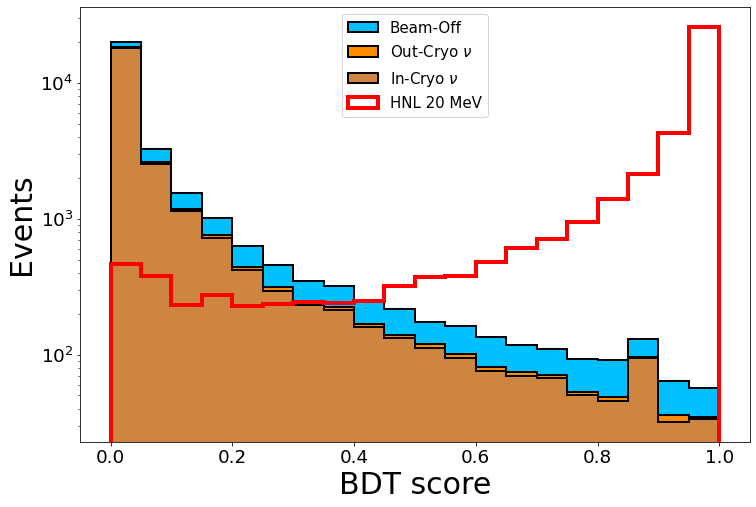

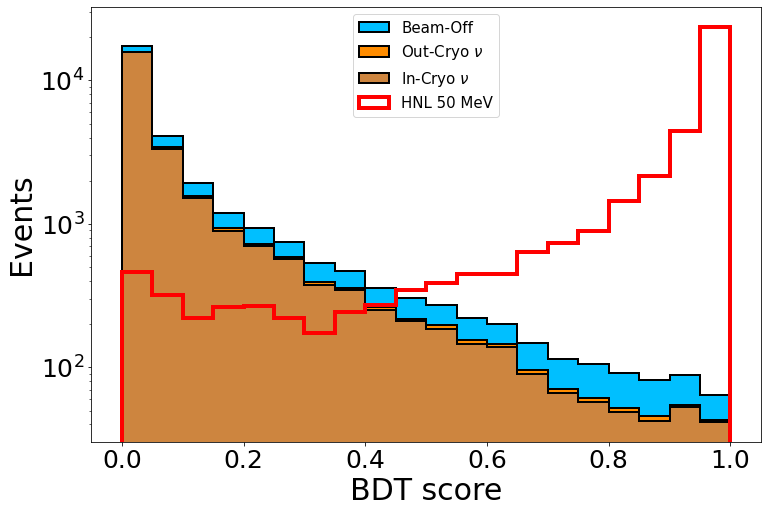

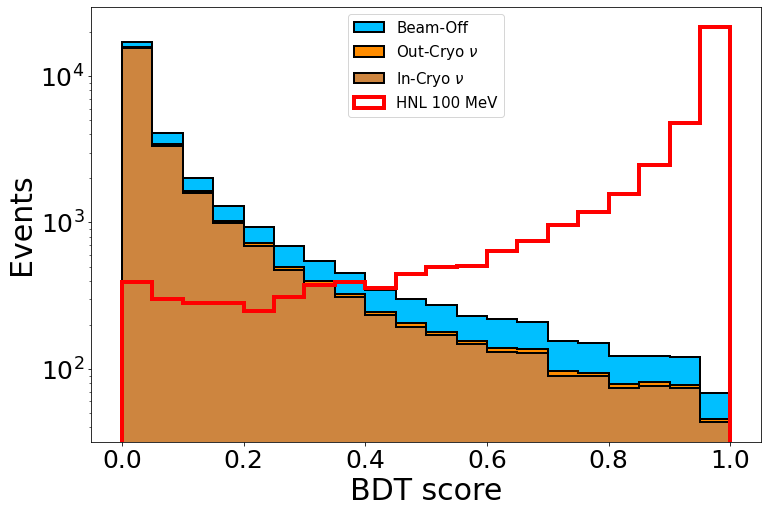

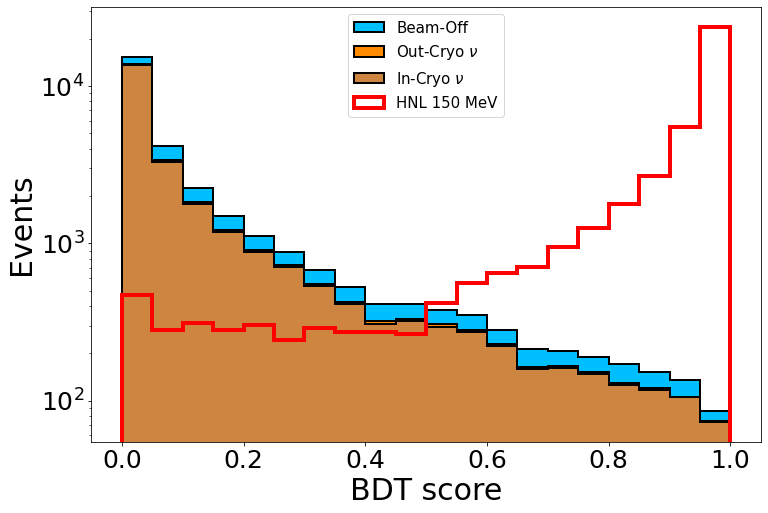

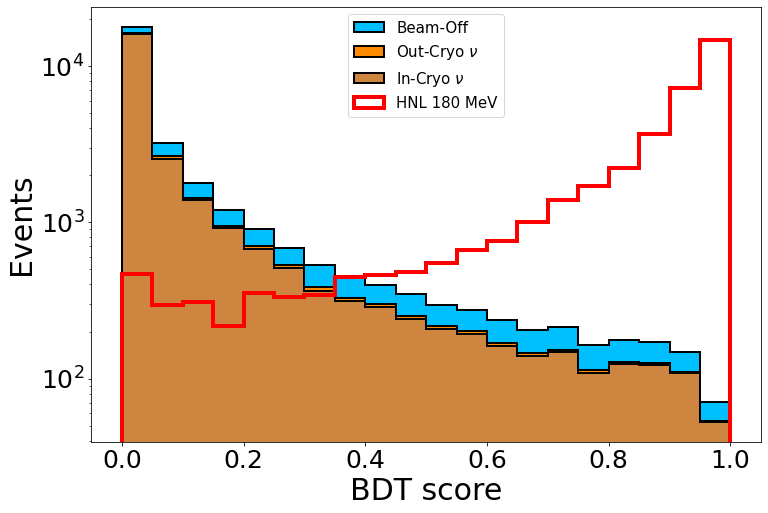

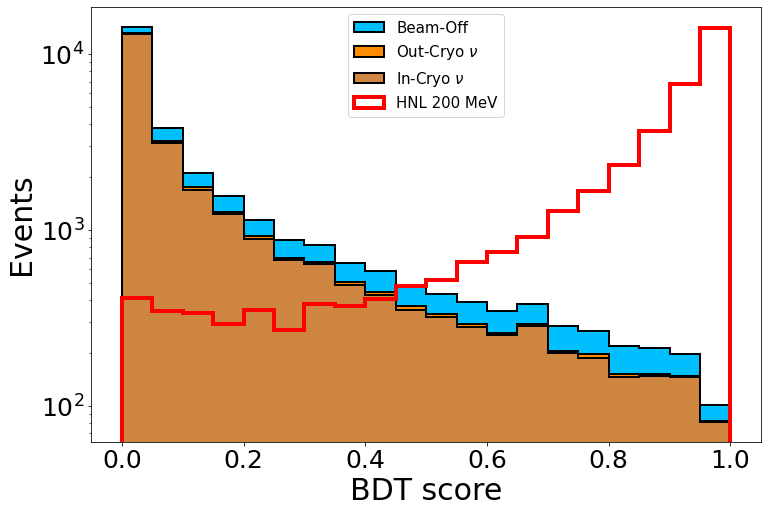

In [6]:
PT.Plot_BDT_output(HNL_masses=Constants.HNL_mass_samples, samples=samples_plot, sample_norms=sample_norms, colours={}, xlims=[0,1.0],
                bins=20,figsize=[12,8], MergeBins=False, density=False, legloc="upper center",logy=True, savefig=False, Run=Params["Run"])

## Plotting Detector Variations histograms

In [10]:
max_y, bin_edges = np.histogram(sample_test_dict["CV"][f'BDT_output_{HNL_mass}MeV'], weights=sample_test_dict["CV"]["weight"], bins=20,range=[0,1.0])
maxium = max(max_y)
max_x = max(bin_edges)
min_x = min(bin_edges)
print(maxium)
print(max_x)
print(min_x)
print("Max minus min is " + str(max_x - min_x))
#plt.ylim(0, maxium*1.3)

4071.4558
1.0
0.0
Max minus min is 1.0


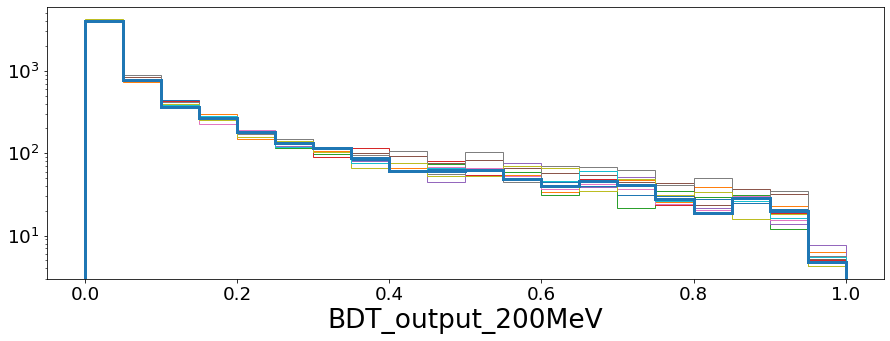

In [19]:
#Plotting the histograms for detector variations
HNL_mass = 200 # - Plot just one
if Params["Load_DetVars"] == True:
    for DetVar in Constants.Detector_variations:
        linewidth = 1
        if DetVar == "CV":
            linewidth = 3
        plt.hist(sample_test_dict[DetVar][f'BDT_output_{HNL_mass}MeV'], weights=sample_test_dict[DetVar]["weight"], bins=20,range=[0,1.0],label=f'{DetVar}',
                 lw=linewidth,histtype="step")
    plt.xlabel(f'BDT_output_{HNL_mass}MeV')
    #plt.legend()
    plt.yscale("log")
    #plt.yscale("linear")
    # plt.ylim(1, maxium*1.3)

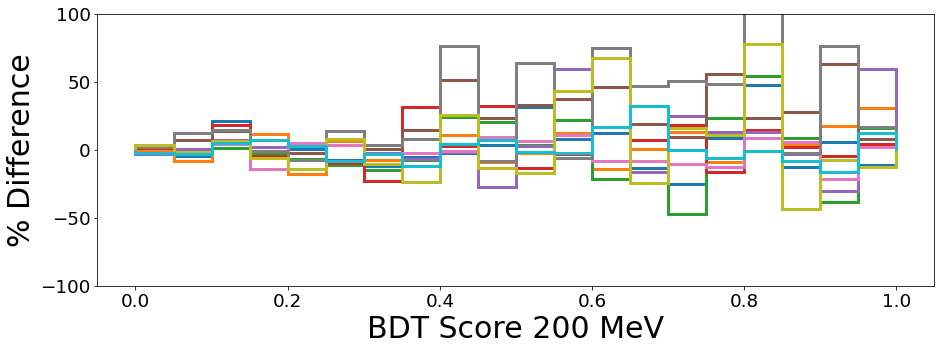

In [21]:
DetVar_percentages_dict = {}
if Params["Load_DetVars"] == True:
    cv_hist, cv_bins = np.histogram(
        sample_test_dict["CV"][f'BDT_output_{HNL_mass}MeV'],
        range=[0,1.0],
        bins=20,
        weights=sample_test_dict["CV"]["weight"])
    bins_cent=(cv_bins[:-1]+cv_bins[1:])/2
    for DetVar in Constants.Detector_variations:
        if DetVar == "CV":
            continue
        perc_list = []
        detvar_hist, bins = np.histogram(
        sample_test_dict[DetVar][f'BDT_output_{HNL_mass}MeV'],
        range=[0,1.0],
        bins=20,
        weights=sample_test_dict[DetVar]["weight"])
        for i in range(len(detvar_hist)):
            frac = detvar_hist[i]/cv_hist[i]
            frac_diff = frac - 1.0
            perc_list.append(frac_diff*100)
        DetVar_percentages_dict[DetVar] = perc_list
        plt.hist(bins_cent,weights=DetVar_percentages_dict[DetVar], bins=20,range=[0,1.0],label=f'{DetVar}',
                lw=linewidth,histtype="step") #just 1 entry for each bin, then "weight" becomes what the percentage is (hacky way, could do something nicer)
    #plt.legend(loc='upper left',frameon=True)
    plt.ylim([-100,100])
    plt.xlabel(f'BDT Score {HNL_mass} MeV', fontsize=30)
    plt.ylabel('% Difference', fontsize=30)
    #plt.yscale()

## Saving output to .root files

In [17]:
def Save_one_hist(hist,name,nbins,xlims):
    tData = ROOT.TH1F(name,name,nbins,xlims[0],xlims[1])
    for i in range(nbins):
        tData.SetBinContent(i+1,hist['hist'][i])
        tData.SetBinError(i+1,hist['err'][i])
    return tData
    
def SaveToRoot_new(nbins,xlims,hist_samples,fileName='test.root'): 
    rFile = ROOT.TFile(f'bdt_output/{fileName}','RECREATE')
    for name in hist_samples:
        tData = Save_one_hist(hist_samples[name],name,nbins,xlims)
        rFile.Write()
    #rFile.Write()
    rFile.Close()

def make_stat_err(hist, SF):
    stat_err = []
    for i in range(0,len(hist[0])):
        error = np.sqrt(hist[0][i])*np.sqrt(SF)
        stat_err.append(error)
    return stat_err

In [27]:
original_theta = Constants.theta_mu_4

SCALE_UP_dict = {20:200,50:50,100:10,150:5,180:5,200:2} #Doing this because the scale factor used in pyhf is bounded

new_theta_dict = {}

train_vs_test_fraction = 0.7 #This was set in 3_BDT_training, need to change if I have changed this there.
SF_test = 1.0/(1-train_vs_test_fraction)

for HNL_mass in Constants.HNL_mass_samples:
    new_theta_dict[HNL_mass] = original_theta*SCALE_UP_dict[HNL_mass]
    SCALE_EVENTS = SCALE_UP_dict[HNL_mass]**4 #The Number of events is proportional to theta^4
    
    if Params["Run"] == "run1":
        SF_signal_list = np.ones(len(sample_test_dict[HNL_mass][f'BDT_output_{HNL_mass}MeV']))*Constants.run1_POT_scaling_dict[HNL_mass]*SF_test*SCALE_EVENTS
        SF_overlay_list = sample_test_dict['overlay']['weight']*Constants.SF_overlay_run1*SF_test
        SF_dirt_list = sample_test_dict['dirtoverlay']['weight']*Constants.SF_dirt_run1
        SF_EXT_list = np.ones(len(sample_test_dict['beamoff'][f'BDT_output_{HNL_mass}MeV']))*Constants.SF_EXT_run1
    if Params["Run"] == "run3":
        SF_signal_list = np.ones(len(sample_test_dict[HNL_mass][f'BDT_output_{HNL_mass}MeV']))*Constants.run3_POT_scaling_dict[HNL_mass]*SF_test*SCALE_EVENTS
        SF_overlay_list = sample_test_dict['overlay']['weight']*Constants.SF_overlay_run3*SF_test
        SF_dirt_list = sample_test_dict['dirtoverlay']['weight']*Constants.SF_dirt_run3
        SF_EXT_list = np.ones(len(sample_test_dict['beamoff'][f'BDT_output_{HNL_mass}MeV']))*Constants.SF_EXT_run3
    
    signal_bdt_hist = np.histogram(sample_test_dict[HNL_mass][f'BDT_output_{HNL_mass}MeV'], bins=20, weights=SF_signal_list, range = (0.0,1.0))
    overlay_bdt_hist = np.histogram(sample_test_dict['overlay'][f'BDT_output_{HNL_mass}MeV'], bins=20, weights=SF_overlay_list, range = (0.0,1.0))
    dirt_bdt_hist = np.histogram(sample_test_dict['dirtoverlay'][f'BDT_output_{HNL_mass}MeV'], bins=20, weights=SF_dirt_list, range = (0.0,1.0))
    EXT_bdt_hist = np.histogram(sample_test_dict['beamoff'][f'BDT_output_{HNL_mass}MeV'], bins=20, weights=SF_EXT_list, range = (0.0,1.0))
    
    signal_bdt_err = make_stat_err(signal_bdt_hist, Constants.run1_POT_scaling_dict[HNL_mass]*SF_test*SCALE_EVENTS)
    overlay_bdt_err = make_stat_err(overlay_bdt_hist, Constants.SF_overlay_run1*SF_test)
    dirt_bdt_err = make_stat_err(dirt_bdt_hist, Constants.SF_dirt_run1)
    EXT_bdt_err = make_stat_err(EXT_bdt_hist, Constants.SF_EXT_run1)
    
    data_h = overlay_bdt_hist[0]+dirt_bdt_hist[0]+EXT_bdt_hist[0]
    
    bkg_overlay = {'bins': np.array(overlay_bdt_hist[1]), 'hist': np.array(overlay_bdt_hist[0]), 'err': np.array(overlay_bdt_err)}
    bkg_dirt = {'bins': np.array(dirt_bdt_hist[1]), 'hist': np.array(dirt_bdt_hist[0]), 'err': np.array(dirt_bdt_err)}
    bkg_EXT = {'bins': np.array(EXT_bdt_hist[1]), 'hist': np.array(EXT_bdt_hist[0]), 'err': np.array(EXT_bdt_err)}
    sig = {'bins': np.array(signal_bdt_hist[1]), 'hist': np.array(signal_bdt_hist[0]), 'err': np.array(signal_bdt_err)}
    data = {'bins': np.array(overlay_bdt_hist[1]), 'hist': np.array(data_h), 'err': np.array(overlay_bdt_err)}
    
    hist_samples = {"bkg_overlay":bkg_overlay,"bkg_dirt":bkg_dirt,"bkg_EXT":bkg_EXT,"signal":sig,"data":data}
    
    SaveToRoot_new(20,[0,1.0],hist_samples,fileName=Params["Run"]+f"_{HNL_mass}MeV_test3.root")

with open('bdt_output/new_theta_dict.pkl', 'wb') as handle: #Saving the scaled thetas dictionary
    pickle.dump(new_theta_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

{20: 0.02, 50: 0.005, 100: 0.001, 150: 0.0005, 180: 0.0005, 200: 0.0002}


# End of code